# Implement Non-Local Means Denoising.
Used skimage library: https://scikit-image.org/docs/stable/auto_examples/filters/plot_nonlocal_means.html

#### Installation of SSIM

In [38]:
pip install pyssim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [21]:
import os
import cv2
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import ssim.ssimlib as pyssim # Only this works for CW-SSIM
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import bm3d

# Non-Local Means Function - Fast Sigma Mode

In [22]:
def nonLocalMeans(noisy):
    sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))
    patch_kw = dict(patch_size=5, patch_distance=6, channel_axis=-1)
    nlm_denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, sigma = sigma_est, fast_mode=True, **patch_kw)
    return nlm_denoise.reshape(noisy.shape)

# Set12

In [23]:
set_12_dir = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset'
print(set_12_dir)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset


### test for single image

Ground Truth Image

Ground Truth image shape: (256, 256, 3)


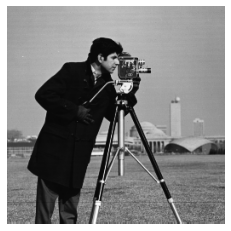

In [5]:
filename = '01'
gt = cv2.imread(set_12_dir+'\\Ground_Truth\\'+filename+'.png')
print('Ground Truth image shape:', gt.shape)
gt_img = Image.fromarray(gt, 'RGB')
gt = gt.astype('float64') / 255.0
plt.imshow(gt)
plt.axis('off')
import logging; logging.getLogger('matplotlib.font_manager').disabled = True

Add Gaussian Noise and Salt&Pepper Noise

In [24]:
def addNoise(image, noiseType, p = 0.001, mean = 0,  sigma = 0.15):
  if noiseType == 'GAUSSIAN':
    noise = np.zeros_like(image)
    noise = cv2.randn(noise, mean, sigma)
    ret = cv2.add(image, noise) #generate and add gaussian noise
    return ret
  elif noiseType == 'SALTNPEPPER':
    output = image.copy()
    noise = np.random.rand(image.shape[0], image.shape[1])
    output[noise < p] = 0
    output[noise > (1-p)] = 255
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gaussian Noise image shape: (256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

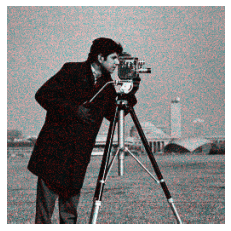

In [6]:
gauss_noisy = addNoise(gt, 'GAUSSIAN')
gauss_noisy_img = Image.fromarray(gauss_noisy, 'RGB')
print('Gaussian Noise image shape:', gauss_noisy.shape)
plt.imshow(gauss_noisy, 'gray')
plt.axis('off')

Print IQA Metrics for Noisy Image

In [7]:
noise_psnr = peak_signal_noise_ratio(gt, gauss_noisy)
noise_ssim = structural_similarity(gt, gauss_noisy, data_range=gauss_noisy.max() - gauss_noisy.min(), channel_axis=2)
noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_noisy_img)
# noise_unique = eng.unique((gt * 255.0).astype(np.uint8), noisy)
# noise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), noisy)
print("Noise PSNR:", noise_psnr, "dB")
print("Noise SSIM", noise_ssim*100, "%")
print("Noise CW-SSIM", noise_cw*100, "%")
# print(noise_unique)
# print(noise_msunique)

Noise PSNR: 21.263100261579815 dB
Noise SSIM 77.169219940283 %
Noise CW-SSIM 39.21256376947567 %


Denoise and Print IQA Metrics

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Denoise PSNR: 28.631542210883847 dB
Denoise SSIM 87.15748396886077 %
Denoise CW-SSIM 95.60539521629362 %


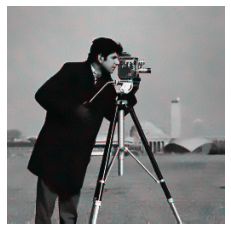

In [8]:
gauss_denoised = nonLocalMeans(gauss_noisy)
gauss_denoised_img = Image.fromarray((gauss_denoised * 255.0).astype(np.uint8), 'RGB')
plt.imshow(gauss_denoised)
plt.axis('off')

gauss_denoise_psnr = peak_signal_noise_ratio(gt, gauss_denoised)
gauss_denoise_ssim = structural_similarity(gt, gauss_denoised, data_range=gauss_denoised.max() - gauss_denoised.min(), channel_axis=2)
gauss_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_denoised_img)
# gauss_denoise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_denoised)
# gauess_denoise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_denoised)
print("Denoise PSNR:", gauss_denoise_psnr, "dB")
print("Denoise SSIM", gauss_denoise_ssim*100, "%")
print("Denoise CW-SSIM", gauss_denoise_cw*100, "%")
# print(gauss_denoise_unique)
# print(gauss_denoise_msunique)

In [15]:
gauss_noisy_final = gauss_noisy* 255.0
noisy_file_save = set_12_dir + '\\'+filename + '_gauss_noisy.png'
cv2.imwrite(noisy_file_save, np.array(gauss_noisy_final))

True

In [39]:
gauss_denoised_final = gauss_denoised* 255.0
print(gauss_denoised_final)
file_save = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\demo.png'
cv2.imwrite(file_save, np.array(gauss_denoised_img))

[[[167.51331967 156.49403338 156.49403338]
  [150.86755258 156.68042111 156.68042111]
  [162.74611706 156.62215252 156.62215252]
  ...
  [155.35952604 152.13326191 152.13326191]
  [163.97078494 152.70149712 152.70149712]
  [147.44225881 152.40606338 152.40606338]]

 [[159.2334391  156.68673255 156.68673255]
  [156.09206029 156.77252676 156.77252676]
  [163.82271881 156.86357265 156.86357265]
  ...
  [145.42597718 152.36973119 152.36973119]
  [162.30923195 152.39286742 152.39286742]
  [149.07983678 152.34375369 152.34375369]]

 [[153.29854101 156.59724339 156.59724339]
  [160.04987361 156.91879867 156.91879867]
  [160.5797427  156.87737037 156.87737037]
  ...
  [149.60426915 152.31687754 152.31687754]
  [153.01421833 152.49440119 152.49440119]
  [158.6986457  152.62191149 152.62191149]]

 ...

 [[129.64414703 120.80711914 120.80711914]
  [126.69822193 123.22945284 123.22945284]
  [127.8130173  123.09292294 123.09292294]
  ...
  [136.15943282 124.65156735 124.65156735]
  [124.85768645 12

True

## Run for all 12 images for Gaussian and S&P Noises

In [25]:
import os
set_12_iqa_pkl = {'01': [], '02': [], '03': [], '04': [], '05': [], '06': [], '07': [], '08': [], '09': [], '10': [], '11': [], '12': []}
set_12_gt_dir = set_12_dir + '\\Ground_Truth'
for filename in os.listdir(set_12_gt_dir):
    print(filename)
    gt = cv2.imread(set_12_gt_dir+'\\'+filename)
    print('Ground Truth image shape:', gt.shape)
    gt_img = Image.fromarray(gt, 'RGB')
    gt = gt.astype('float64') / 255.0
    
    gauss_noisy = addNoise(gt, 'GAUSSIAN')
    gauss_noisy_img = Image.fromarray(gauss_noisy, 'RGB')
    gauss_noisy_final = gauss_noisy* 255.0
    gauss_noisy_file_save = set_12_dir + '\\Noisy\\'+filename[0:2] + '_gauss_noisy.png'
    cv2.imwrite(gauss_noisy_file_save, np.array(gauss_noisy_final))
    print('Gaussian Noise image saved at:', gauss_noisy_file_save)

    sp_noisy = addNoise(gt, 'GAUSSIAN')
    sp_noisy_img = Image.fromarray(sp_noisy, 'RGB')
    sp_noisy_final = sp_noisy* 255.0
    sp_noisy_file_save = set_12_dir + '\\Noisy\\'+filename[0:2] + '_sp_noisy.png'
    cv2.imwrite(sp_noisy_file_save, np.array(sp_noisy_final))
    print('Salt&Pepper Noise image saved at:', sp_noisy_file_save)

    gauss_noise_psnr = peak_signal_noise_ratio(gt, gauss_noisy)
    gauss_noise_ssim = structural_similarity(gt, gauss_noisy, data_range=gauss_noisy.max() - gauss_noisy.min(), channel_axis=2)
    gauss_noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_noisy_img)
    # gauss_noise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # gauss_noise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)
    
    gauss_denoised = nonLocalMeans(gauss_noisy)
    gauss_denoised_img = Image.fromarray((gauss_denoised * 255.0).astype(np.uint8), 'RGB')
    gauss_denoised_final = gauss_denoised* 255.0
    gauss_denoised_file_save = set_12_dir + '\\Denoised\\'+filename[0:2] + '_gauss_denoised.png'
    cv2.imwrite(gauss_denoised_file_save, np.array(gauss_denoised_final))
    print('Gaussian Denoised image saved at:', gauss_denoised_file_save)

    gauss_denoise_psnr = peak_signal_noise_ratio(gt, gauss_denoised)
    gauss_denoise_ssim = structural_similarity(gt, gauss_denoised, data_range=gauss_denoised.max() - gauss_denoised.min(), channel_axis=2)
    gauss_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_denoised_img)
    # gauss_denoise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # gauss_denoise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)

    sp_noise_psnr = peak_signal_noise_ratio(gt, sp_noisy)
    sp_noise_ssim = structural_similarity(gt, sp_noisy, data_range=sp_noisy.max() - sp_noisy.min(), channel_axis=2)
    sp_noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(sp_noisy_img)
    # gauss_noise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # gauss_noise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)
    
    sp_denoised = nonLocalMeans(sp_noisy)
    sp_denoised_img = Image.fromarray((sp_denoised * 255.0).astype(np.uint8), 'RGB')
    sp_denoised_final = sp_denoised* 255.0
    sp_denoised_file_save = set_12_dir + '\\Denoised\\'+filename[0:2] + '_sp_denoised.png'
    cv2.imwrite(sp_denoised_file_save, np.array(sp_denoised_final))
    print('SP Denoised image saved at:', sp_denoised_file_save)

    sp_denoise_psnr = peak_signal_noise_ratio(gt, sp_denoised)
    sp_denoise_ssim = structural_similarity(gt, sp_denoised, data_range=sp_denoised.max() - sp_denoised.min(), channel_axis=2)
    sp_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(sp_denoised_img)
    # gauss_denoise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # gauss_denoise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)
    
    set_12_iqa = {"Gaussian Noise": (str(gauss_noise_psnr)+' dB', str(gauss_noise_ssim)+' %', str(gauss_noise_cw)+' %'), "Gaussian Denoise": (str(gauss_denoise_psnr)+' dB', str(gauss_denoise_ssim)+' %', str(gauss_denoise_cw)), "S&P Noise": (str(sp_noise_psnr)+' dB', str(sp_noise_ssim)+' %', str(sp_noise_cw)+' %'), "S&P Denoise": (str(sp_denoise_psnr)+' dB', str(sp_denoise_ssim)+' %', str(sp_denoise_cw))}
    file_index = filename[0:2]
    set_12_iqa_pkl[file_index].append(set_12_iqa)
print(set_12_iqa_pkl)


01.png
Ground Truth image shape: (256, 256, 3)
Gaussian Noise image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\Noisy\01_gauss_noisy.png
Salt&Pepper Noise image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\Noisy\01_sp_noisy.png
Gaussian Denoised image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\Denoised\01_gauss_denoised.png
SP Denoised image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\Denoised\01_sp_denoised.png
02.png
Ground Truth image shape: (256, 256, 3)
Gaussian Noise image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\Noisy\02_gauss_noisy.png
Salt&Pepper Noise image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE

In [28]:
with open(set_12_dir+'\\Set12_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(set_12_iqa_pkl, pkl_file)
    print("Set-12 IQA Metrics saved at:", set_12_dir+'\\Set12_IQA.pkl')

Set-12 IQA Metrics saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\Set12_IQA.pkl


In [29]:
with open(set_12_dir+'\\Set12_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

IQA LensBlur
{'01': [{'Gaussian Noise': ('21.256909129808996 dB', '0.7716890932746567 %', '0.3935082725596495 %'), 'Gaussian Denoise': ('28.69388758977326 dB', '0.8868758296601005 %', '0.9552295539523532'), 'S&P Noise': ('21.234023467021572 dB', '0.7718750579780319 %', '0.3938125570056924 %')}], '02': [{'Gaussian Noise': ('21.269248629499128 dB', '0.7513607726718826 %', '0.3849584465303441 %'), 'Gaussian Denoise': ('30.91483360363494 dB', '0.8493459486293591 %', '0.9297420063955926'), 'S&P Noise': ('21.25739374221922 dB', '0.7476211333004495 %', '0.3849419812435435 %')}], '03': [{'Gaussian Noise': ('21.230788731350337 dB', '0.7752303157798398 %', '0.44467667033018926 %'), 'Gaussian Denoise': ('29.561237143237218 dB', '0.8926254266359629 %', '0.9885168938715199'), 'S&P Noise': ('21.254295088706478 dB', '0.7785237420183665 %', '0.44465849303981386 %')}], '04': [{'Gaussian Noise': ('21.251950290038426 dB', '0.7993282300979067 %', '0.4591171373857556 %'), 'Gaussian Denoise': ('28.144344134

# BM3D Denoising for Set-12

In [79]:
! pip install bm3d

     ---------------------------------------- 1.1/1.1 MB 3.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Test for 1 image

In [95]:
filename = '08'
gt = cv2.imread(set_12_dir+'\\Ground_Truth\\'+filename+'.png')
print('Ground Truth image shape:', gt.shape)
gt_img = Image.fromarray(gt, 'RGB')
gt = gt.astype('float64') / 255.0

gauss_bm3d_noisy = addNoise(gt, 'GAUSSIAN')
gauss_bm3d_noisy_img = Image.fromarray(gauss_bm3d_noisy, 'RGB')
print(gauss_bm3d_noisy)

Ground Truth image shape: (512, 512, 3)
[[[ 0.57749527  0.63529412  0.63529412]
  [ 0.7630283   0.63529412  0.63529412]
  [ 0.56074458  0.63529412  0.63529412]
  ...
  [ 0.6110411   0.6627451   0.6627451 ]
  [ 0.54827081  0.60784314  0.60784314]
  [ 0.46971483  0.50196078  0.50196078]]

 [[ 0.67214659  0.63529412  0.63529412]
  [ 0.66608659  0.63529412  0.63529412]
  [ 0.59367898  0.63529412  0.63529412]
  ...
  [ 0.69657429  0.6627451   0.6627451 ]
  [ 0.46189618  0.60784314  0.60784314]
  [ 0.39373283  0.50196078  0.50196078]]

 [[ 0.30166998  0.63529412  0.63529412]
  [ 0.69468593  0.63529412  0.63529412]
  [ 0.58645661  0.63529412  0.63529412]
  ...
  [ 0.42822519  0.6627451   0.6627451 ]
  [ 0.81209752  0.60784314  0.60784314]
  [ 0.53346341  0.50196078  0.50196078]]

 ...

 [[ 0.32184914  0.16470588  0.16470588]
  [ 0.23217501  0.16470588  0.16470588]
  [ 0.39938626  0.19215686  0.19215686]
  ...
  [ 0.1834805   0.40784314  0.40784314]
  [ 0.60963083  0.39215686  0.39215686]
  [ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Denoise PSNR: 30.7883 dB
Denoise SSIM 83.8245 %
Denoise CW-SSIM 98.5882 %


noisy image shape (512, 512, 3)
denoised image shape (512, 512, 3)


(-0.5, 511.5, 511.5, -0.5)

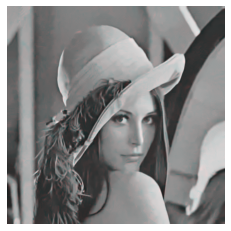

In [93]:
gauss_bm3d_denoised = bm3d.bm3d(gauss_bm3d_noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES)
gauss_bm3d_denoised_img = Image.fromarray((gauss_bm3d_denoised * 255.0).astype(np.uint8), 'RGB')
gauss_bm3d_denoise_psnr = peak_signal_noise_ratio(gt, gauss_bm3d_denoised)
gauss_bm3d_denoise_ssim = structural_similarity(gt, gauss_bm3d_denoised, data_range=gauss_bm3d_denoised.max() - gauss_bm3d_denoised.min(), channel_axis=2)
gauss_bm3d_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_bm3d_denoised_img)
# denoised = np.ascontiguousarray((gauss_bm3d_denoised * 255.0).astype(np.uint8)) # for UNIQUE IQA Metric
# noise_unique = eng.unique((gt * 255.0).astype(np.uint8), denoised)

print("Denoise PSNR:", np.round(gauss_bm3d_denoise_psnr, 4), "dB")
print("Denoise SSIM", np.round(gauss_bm3d_denoise_ssim*100, 4), "%")
print("Denoise CW-SSIM", np.round(gauss_bm3d_denoise_cw*100, 4), "%")
print("\n")
print("noisy image shape", gauss_bm3d_noisy.shape)
print("denoised image shape", gauss_bm3d_denoised.shape)
# print(noise_unique)
plt.imshow(gauss_bm3d_denoised)
plt.axis('off')


## Experimentally found sigma_psd = 0.13 works best for Set12 images

In [113]:
gt = cv2.imread(set_12_dir+'\\'+'08.png')
print('Ground Truth image shape:', gt.shape)
gt_img = Image.fromarray(gt, 'RGB')
gt = gt.astype('float64') / 255.0

gauss_noisy = addNoise(gt, 'GAUSSIAN')
gauss_noisy_img = Image.fromarray(gauss_noisy, 'RGB')
print('Gaussian Noise image shape:', gauss_noisy.shape)

sp_noisy = addNoise(gt, 'GAUSSIAN')
sp_noisy_img = Image.fromarray(sp_noisy, 'RGB')
print('Salt&Pepper Noise image shape:', sp_noisy.shape)

gauss_noise_psnr = peak_signal_noise_ratio(gt, gauss_noisy)
gauss_noise_ssim = structural_similarity(gt, gauss_noisy, data_range=gauss_noisy.max() - gauss_noisy.min(), channel_axis=2)
gauss_noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_noisy_img)
# gauss_noise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
# gauss_noise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)

gauss_denoised = bm3d.bm3d(gauss_bm3d_noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES)
print('BM3D deNoise image shape:', gauss_denoised.shape)
gauss_denoised_img = Image.fromarray((gauss_denoised * 255.0).astype(np.uint8), 'RGB')

# import pdb; pdb.set_trace()
gauss_denoise_psnr = peak_signal_noise_ratio(gt, gauss_denoised)
gauss_denoise_ssim = structural_similarity(gt, gauss_denoised, data_range=gauss_denoised.max() - gauss_denoised.min(), channel_axis=2)
gauss_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_denoised_img)
# gauss_denoise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
# gauss_denoise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)

sp_noise_psnr = peak_signal_noise_ratio(gt, sp_noisy)
sp_noise_ssim = structural_similarity(gt, sp_noisy, data_range=sp_noisy.max() - sp_noisy.min(), channel_axis=2)
sp_noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(sp_noisy_img)
# gauss_noise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
# gauss_noise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)

sp_denoised = bm3d.bm3d(gauss_bm3d_noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES)
sp_denoised_img = Image.fromarray((sp_denoised * 255.0).astype(np.uint8), 'RGB')

sp_denoise_psnr = peak_signal_noise_ratio(gt, sp_denoised)
sp_denoise_ssim = structural_similarity(gt, sp_denoised, data_range=sp_denoised.max() - sp_denoised.min(), channel_axis=2)
sp_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(sp_denoised_img)

Ground Truth image shape: (512, 512, 3)
Gaussian Noise image shape: (512, 512, 3)
Salt&Pepper Noise image shape: (512, 512, 3)
BM3D deNoise image shape: (512, 512, 3)


## Run for all Images

In [26]:
import os
import bm3d
set_12_dir = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset'
set_12_iqa_pkl = {'01': [], '02': [], '03': [], '04': [], '05': [], '06': [], '07': [], '08': [], '09': [], '10': [], '11': [], '12': []}
set_12_gt_dir = set_12_dir + '\\Ground_Truth'
for filename in os.listdir(set_12_gt_dir):
    print(filename)
    gt = cv2.imread(set_12_gt_dir+'\\'+filename)
    print('Ground Truth image shape:', gt.shape)
    gt_img = Image.fromarray(gt, 'RGB')
    gt = gt.astype('float64') / 255.0
    
    gauss_bm3d_noisy = addNoise(gt, 'GAUSSIAN')
    gauss_bm3d_noisy_img = Image.fromarray(gauss_bm3d_noisy, 'RGB')
    print('Gaussian Noise image shape:', gauss_bm3d_noisy.shape)

    sp_bm3d_noisy = addNoise(gt, 'GAUSSIAN')
    sp_bm3d_noisy_img = Image.fromarray(sp_bm3d_noisy, 'RGB')
    print('Salt&Pepper Noise image shape:', sp_bm3d_noisy.shape)

    gauss_bm3d_noise_psnr = peak_signal_noise_ratio(gt, gauss_bm3d_noisy)
    gauss_bm3d_noise_ssim = structural_similarity(gt, gauss_bm3d_noisy, data_range=gauss_bm3d_noisy.max() - gauss_bm3d_noisy.min(), channel_axis=2)
    gauss_bm3d_noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_bm3d_noisy_img)
    # gauss_noise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # gauss_noise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)
    
    gauss_bm3d_denoised = bm3d.bm3d(gauss_bm3d_noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    print('BM3D deNoise image shape:', gauss_bm3d_denoised.shape)
    gauss_bm3d_denoised_img = Image.fromarray((gauss_bm3d_denoised * 255.0).astype(np.uint8), 'RGB')
    gauss_bm3d_denoised_final = gauss_bm3d_denoised* 255.0
    gauss_BM3D_denoised_file_save = set_12_dir + '\\BM3D\\BM3D_Denoised\\'+filename[0:2] + '_gauss_bm3d_denoised.png'
    cv2.imwrite(gauss_BM3D_denoised_file_save, np.array(gauss_bm3d_denoised_final))
    print('Gaussian BM3D Denoised image saved at:', gauss_BM3D_denoised_file_save)

    # import pdb; pdb.set_trace()
    gauss_bm3d_denoise_psnr = peak_signal_noise_ratio(gt, gauss_bm3d_denoised)
    gauss_bm3d_denoise_ssim = structural_similarity(gt, gauss_bm3d_denoised, data_range=gauss_bm3d_denoised.max() - gauss_bm3d_denoised.min(), channel_axis=2)
    gauss_bm3d_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_bm3d_denoised_img)
    # gauss_denoise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # gauss_denoise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)

    sp_bm3d_noise_psnr = peak_signal_noise_ratio(gt, sp_bm3d_noisy)
    sp_bm3d_noise_ssim = structural_similarity(gt, sp_bm3d_noisy, data_range=sp_bm3d_noisy.max() - sp_bm3d_noisy.min(), channel_axis=2)
    sp_bm3d_noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(sp_bm3d_noisy_img)
    # gauss_noise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # gauss_noise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)
    
    sp_bm3d_denoised = bm3d.bm3d(sp_bm3d_noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    sp_bm3d_denoised_img = Image.fromarray((sp_bm3d_denoised * 255.0).astype(np.uint8), 'RGB')
    sp_bm3d_denoised_final = sp_bm3d_denoised* 255.0
    sp_BM3D_denoised_file_save = set_12_dir + '\\BM3D\\BM3D_Denoised\\'+filename[0:2] + '_sp_bm3d_denoised.png'
    cv2.imwrite(sp_BM3D_denoised_file_save, np.array(sp_bm3d_denoised_final))
    print('SP BM3D Denoised image saved at:', sp_BM3D_denoised_file_save)

    sp_bm3d_denoise_psnr = peak_signal_noise_ratio(gt, sp_bm3d_denoised)
    sp_bm3d_denoise_ssim = structural_similarity(gt, sp_bm3d_denoised, data_range=sp_bm3d_denoised.max() - sp_bm3d_denoised.min(), channel_axis=2)
    sp_bm3d_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(sp_bm3d_denoised_img)
    # gauss_denoise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # gauss_denoise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_noisy)
    # import pdb; pdb.set_trace()
    set_12_iqa = {"Gaussian Noise": (str(gauss_bm3d_noise_psnr)+' dB', str(gauss_bm3d_noise_ssim)+' %', str(gauss_bm3d_noise_cw)+' %'), "Gaussian Denoise": (str(gauss_bm3d_denoise_psnr)+' dB', str(gauss_bm3d_denoise_ssim)+' %', str(gauss_bm3d_denoise_cw)), "S&P Noise": (str(sp_bm3d_noise_psnr)+' dB', str(sp_bm3d_noise_ssim)+' %', str(sp_bm3d_noise_cw)+' %'), "SP Denoise": (str(sp_bm3d_denoise_psnr)+' dB', str(sp_bm3d_denoise_ssim)+' %', str(sp_bm3d_denoise_cw))}
    file_index = filename[0:2]
    set_12_iqa_pkl[file_index].append(set_12_iqa)
print(set_12_iqa_pkl)


01.png
Ground Truth image shape: (256, 256, 3)
Gaussian Noise image shape: (256, 256, 3)
Salt&Pepper Noise image shape: (256, 256, 3)
BM3D deNoise image shape: (256, 256, 3)
Gaussian BM3D Denoised image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\BM3D\BM3D_Denoised\01_gauss_bm3d_denoised.png
SP BM3D Denoised image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\BM3D\BM3D_Denoised\01_sp_bm3d_denoised.png
02.png
Ground Truth image shape: (256, 256, 3)
Gaussian Noise image shape: (256, 256, 3)
Salt&Pepper Noise image shape: (256, 256, 3)
BM3D deNoise image shape: (256, 256, 3)
Gaussian BM3D Denoised image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\BM3D\BM3D_Denoised\02_gauss_bm3d_denoised.png
SP BM3D Denoised image saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\E

In [26]:
with open(set_12_dir+'\\BM3D\\Set12_BM3D_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(set_12_iqa_pkl, pkl_file)
    print("Set-12 IQA Metrics saved at:", set_12_dir+'\\BM3D\\Set12_BM3D_IQA.pkl')
with open(set_12_dir+'\\BM3D\\Set12_BM3D_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

Set-12 IQA Metrics saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\BM3D\Set12_BM3D_IQA.pkl
IQA LensBlur
{'01': [{'Gaussian Noise': ('21.225672936292156 dB', '0.7735255630591532 %', '0.39520122106314004 %'), 'Gaussian Denoise': ('28.100536850958843 dB', '0.832292925188454 %', '0.9463653491790658'), 'S&P Noise': ('21.29949818230059 dB', '0.7691984492851969 %', '0.39545765594975274 %')}], '02': [{'Gaussian Noise': ('21.24024796967123 dB', '0.7515511185703412 %', '0.38541022647322287 %'), 'Gaussian Denoise': ('31.8196536442807 dB', '0.8402353593233661 %', '0.9263246768075221'), 'S&P Noise': ('21.249175993495342 dB', '0.7466249476861778 %', '0.3837168166308237 %')}], '03': [{'Gaussian Noise': ('21.261718320885347 dB', '0.7768443451677731 %', '0.4450840423800561 %'), 'Gaussian Denoise': ('28.86649141803092 dB', '0.8604882264698145 %', '0.9844092580542354'), 'S&P Noise': ('21.24793713457845 dB', '0.7731732323568631 %', '0.44651

# SIDD

#### Install mat73 and tqdm

In [18]:
! pip install mat73
! pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Import Libraries to read MATLAB files for SIDD Small Raw

In [19]:
%matplotlib inline
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from scipy.io import loadmat
from mat73 import loadmat as load_imgs
from skimage import io, img_as_float
from skimage.restoration import denoise_tv_chambolle
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.restoration import denoise_nl_means, estimate_sigma
import pickle
import ssim.ssimlib as pyssim # Only this works for CW-SSIM

In [42]:
# directory = '/content/drive/MyDrive/ECE_6258_DIP/DIP_final_project/Datasets/SIDD_Small_Raw_Only/Data'
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\SIDD_Small_Raw_Only\Data'
files = os.listdir(directory)
psnr_diff = []
ssim_diff = []

for filename in tqdm(files):
  f = os.path.join(directory, filename)
  print("File:", filename)

  for mats in os.listdir(f):
    if mats.startswith("G"):
      gt = load_imgs(os.path.join(f, mats))['x']
    elif mats.startswith("N"):
      noisy = load_imgs(os.path.join(f, mats))['x']
    else:
      continue
  
  # import pdb; pdb.set_trace()
  gt = gt.astype('float32') / 255.0
  noisy = noisy.astype('float32')/255.0
  noise_psnr = peak_signal_noise_ratio(gt, noisy)
  noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min())#, channel_axis=2)
  print("Before:", noise_psnr, "/", noise_ssim*100)
  print(noisy.shape)
  denoised = nonLocalMeans(noisy)
  #plt.imsave(f+"/"+filename[:4]+"_DENOISED.png", denoised, cmap='gray')
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)
  denoise_ssim = structural_similarity(gt, denoised, data_range=(noisy.min(), noisy.max()))
  print("After:", denoise_psnr, "/", denoise_ssim*100,
        "\n-----------------------------------------------------")
  psnr_diff.append(denoise_psnr - noise_psnr)
  ssim_diff.append(denoise_ssim - noise_ssim)
  # cv2.imwrite(f+'GT.jpg', gt)
  # cv2.imwrite(f+'NOISY.jpg', noisy)
  # cv2.imwrite(f+'DENOISED.jpg', denoised)

  0%|          | 0/160 [00:00<?, ?it/s]

File: 0001_001_S6_00100_00060_3200_L
Before: 93.47167506548077 / 89.8232619600552
(3000, 5328)


NotImplementedError: Non-local means denoising is only implemented for 2D, 3D or 4D grayscale or multichannel images.

In [ ]:
psnr_diff, ssim_diff = np.array(psnr_diff), np.array(ssim_diff)
mean_psnr, mean_ssim = np.mean(psnr_diff), np.mean(ssim_diff)
max_psnr, max_ssim = np.max(psnr_diff), np.max(ssim_diff)
min_psnr, min_ssim = np.min(psnr_diff), np.min(ssim_diff)
print("PSNR Mean:", mean_psnr, "/", "SSIM Mean:", mean_ssim)
print("PSNR Max:", max_psnr, "/", "SSIM Mean:", max_ssim)
print("PSNR Min:", min_psnr, "/", "SSIM Mean:", min_ssim)

PSNR Mean: -3.3870138816523174 / SSIM Mean: -0.05856678382826719
PSNR Max: 9.857112429303761 / SSIM Mean: 0.23560754697183872
PSNR Min: -17.795589749954132 / SSIM Mean: -0.5038789454574348


# CURE-OR

In [34]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\03_underexposure'
print(noisy_dir)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure


Ground Truth image shape: (968, 648, 3)


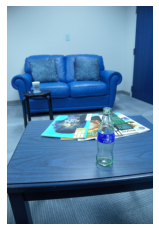

In [36]:
gt_one_path = gt_dir + '\\4_5_1_001_01_0.jpg'
gt = cv2.imread(gt_one_path)
print('Ground Truth image shape:', gt.shape)
gt_img = Image.fromarray(gt, 'RGB')
gt = gt.astype('float64') / 255.0
plt.imshow(gt)
plt.axis('off')
import logging; logging.getLogger('matplotlib.font_manager').disabled = True

Noise image shape: (968, 648, 3)


(-0.5, 647.5, 967.5, -0.5)

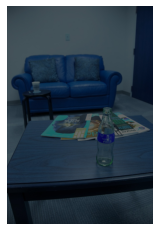

In [37]:
noisy_one_path = noisy_dir + '\\4_5_1_001_03_1.jpg'
noisy = cv2.imread(noisy_one_path)
noisy_img = Image.fromarray(noisy, 'RGB')
print('Noise image shape:', noisy.shape)
plt.imshow(noisy)
plt.axis('off')

<ipython-input-40-744b04dadc9b>:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(noisy, denoised)


Denoise PSNR: 13.178105391611616 dB
Denoise SSIM 0.02789516437081449 %
Denoise CW-SSIM 79.54056785709945 %


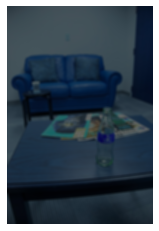

In [40]:
denoised = nonLocalMeans(noisy)
denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
plt.imshow(denoised)
plt.axis('off')

denoise_psnr = peak_signal_noise_ratio(noisy, denoised)
denoise_ssim = structural_similarity(noisy, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
denoise_cw = pyssim.SSIM(noisy_img).cw_ssim_value(denoised_img)
# gauss_denoise_unique = eng.unique((gt * 255.0).astype(np.uint8), gauss_denoised)
# gauess_denoise_msunique = eng.msunique((gt * 255.0).astype(np.uint8), gauss_denoised)
print("Denoise PSNR:", denoise_psnr, "dB")
print("Denoise SSIM", denoise_ssim*100, "%")
print("Denoise CW-SSIM", denoise_cw*100, "%")

In [125]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\08_dirtylens2'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised_final = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised_final))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(noisy, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"Dirty Lens 2 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2
4_5_1_001_08_1.jpg
4_5_1_001_01_0.jpg


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_denoised\4_5_1_001_08_1_denoised.jpg


<ipython-input-125-fd24ed958f21>:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(noisy, denoised)


4_5_1_002_08_1.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_denoised\4_5_1_002_08_1_denoised.jpg
4_5_1_003_08_1.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_denoised\4_5_1_003_08_1_denoised.jpg
4_5_1_004_08_1.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_denoised\4_5_1_004_08_1_denoised.jpg
4_5_1_005_08_1.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_denoised\4_5_1_005_08_1_denoised.jpg
4_5_1_006_08_1.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Dat

In [126]:
with open(directory+'\\CURE_OR_08_dirtylens2_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("CURE-OR Underexposure IQA Metrics saved at:", set_12_dir+'\\CURE_OR_08_dirtylens2_IQA.pkl')

with open(directory+'\\CURE_OR_08_dirtylens2_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

CURE-OR Underexposure IQA Metrics saved at: D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\CURE_OR_08_dirtylens2_IQA.pkl
IQA LensBlur
{'001': [{'Dirty Lens 2 distortion': ('22.310166952739856 dB', '0.7413401745922511 %', '0.7718541221394672 %'), 'NLM Denoise': ('1.6652399677508082e-05 dB', '0.0002789516437081449 %', '0.7298456273566508')}], '002': [{'Dirty Lens 2 distortion': ('22.46654894852282 dB', '0.7448208885427539 %', '0.7719596102722964 %'), 'NLM Denoise': ('1.6427205320549754e-05 dB', '0.0002789516437081449 %', '0.731485449319093')}], '003': [{'Dirty Lens 2 distortion': ('23.39762302074614 dB', '0.7679139321275746 %', '0.785112056087526 %'), 'NLM Denoise': ('1.4998132763138881e-05 dB', '0.0002789516437081449 %', '0.7358743131815075')}], '004': [{'Dirty Lens 2 distortion': ('22.538801523452683 dB', '0.7457785826989539 %', '0.7780815886714687 %'), 'NLM Denoise': ('1.8487704161050877e-05 dB', '0.0002789516437081449 %', '0.73

# CURE-OR NLM LEVEL 5

In [15]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\03_underexposure_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)
    

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"03 Underexposure Level 5 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_03_underexposure_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("CURE-OR Underexposure IQA Metrics saved at:", set_12_dir+'\\CURE_OR_03_underexposure_level3_IQA.pkl')

with open(directory+'\\CURE_OR_03_underexposure_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3
4_5_1_001_03_3.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3_denoised\4_5_1_001_03_3_denoised.jpg


<ipython-input-15-0249e8602a97>:33: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_03_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3_denoised\4_5_1_002_03_3_denoised.jpg
4_5_1_003_03_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3_denoised\4_5_1_003_03_3_denoised.jpg
4_5_1_004_03_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3_denoised\4_5_1_004_03_3_denoised.jpg
4_5_1_005_03_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3_denoised\4_5_1_005_03_3_denoised.jpg
4_5_1_006_03_3.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fa

In [16]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\04_overexposure_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    print(gt)

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    # print(noisy)
    # import pdb; pdb.set_trace()
    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"04 Overexposure Level 5 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_04_overexposure_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", set_12_dir+'\\CURE_OR_04_overexposure_level3_IQA.pkl')

with open(directory+'\\CURE_OR_04_overexposure_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\04_overexposure_level3
4_5_1_001_04_3.jpg
4_5_1_001_01_0.jpg
[[[105 132 153]
  [106 133 154]
  [107 134 155]
  ...
  [ 12  43  88]
  [ 12  43  88]
  [ 14  45  90]]

 [[107 134 155]
  [107 134 155]
  [108 135 156]
  ...
  [ 12  43  88]
  [ 12  43  88]
  [ 13  44  89]]

 [[106 133 154]
  [107 134 155]
  [108 135 156]
  ...
  [ 12  43  88]
  [ 13  44  89]
  [ 13  44  89]]

 ...

 [[ 50  72  90]
  [ 42  64  82]
  [ 37  61  81]
  ...
  [ 57  88 109]
  [ 56  87 108]
  [ 53  84 105]]

 [[ 51  71  89]
  [ 46  68  86]
  [ 44  68  88]
  ...
  [ 47  76  97]
  [ 39  68  89]
  [ 41  70  91]]

 [[ 59  79  97]
  [ 59  81  99]
  [ 50  71  92]
  ...
  [ 43  72  93]
  [ 28  57  78]
  [ 39  68  89]]]


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\04_overexposure_level3_denoised\4_5_1_001_04_3_denoised.jpg


<ipython-input-16-19e19ee3d987>:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_04_3.jpg
4_5_1_002_01_0.jpg
[[[103 130 150]
  [105 132 152]
  [105 132 152]
  ...
  [ 12  40  87]
  [ 15  43  90]
  [ 14  42  89]]

 [[103 130 150]
  [104 131 151]
  [105 132 152]
  ...
  [ 14  42  89]
  [ 14  42  89]
  [ 12  40  87]]

 [[105 132 152]
  [105 132 152]
  [105 132 152]
  ...
  [ 13  41  88]
  [ 15  43  90]
  [ 16  44  91]]

 ...

 [[ 38  62  82]
  [ 32  56  76]
  [ 38  61  83]
  ...
  [ 55  87 110]
  [ 58  90 113]
  [ 60  92 115]]

 [[ 43  64  85]
  [ 43  67  87]
  [ 49  72  94]
  ...
  [ 41  69  93]
  [ 43  71  95]
  [ 43  74  97]]

 [[ 53  74  95]
  [ 49  70  91]
  [ 47  70  92]
  ...
  [ 31  57  81]
  [ 42  70  94]
  [ 55  83 107]]]
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\04_overexposure_level3_denoised\4_5_1_002_04_3_denoised.jpg
4_5_1_003_04_3.jpg
4_5_1_003_01_0.jpg
[[[ 88 117 138]
  [ 89 118 139]
  [ 87 116 137]
  ...
  [ 11  36  80]
  [  9  34  78]
  [ 10  35  79]]

 [[ 87

In [17]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\05_blur_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"05 Blur Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_05_blur_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", set_12_dir+'\\CURE_OR_05_blur_level3_IQA.pkl')

with open(directory+'\\CURE_OR_05_blur_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3
4_5_1_001_05_3.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_denoised\4_5_1_001_05_3_denoised.jpg


<ipython-input-17-d27f69a659b2>:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_05_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_denoised\4_5_1_002_05_3_denoised.jpg
4_5_1_003_05_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_denoised\4_5_1_003_05_3_denoised.jpg
4_5_1_004_05_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_denoised\4_5_1_004_05_3_denoised.jpg
4_5_1_005_05_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_denoised\4_5_1_005_05_3_denoised.jpg
4_5_1_006_05_3.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project

In [18]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\06_contrast_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"06 Contrast Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_06_contrast_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", set_12_dir+'\\CURE_OR_06_contrast_level3_IQA.pkl')

with open(directory+'\\CURE_OR_06_contrast_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3
4_5_1_001_06_3.jpg
4_5_1_001_01_0.jpg


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_denoised\4_5_1_001_06_3_denoised.jpg


<ipython-input-18-ab892fb08826>:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_06_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_denoised\4_5_1_002_06_3_denoised.jpg
4_5_1_003_06_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_denoised\4_5_1_003_06_3_denoised.jpg
4_5_1_004_06_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_denoised\4_5_1_004_06_3_denoised.jpg
4_5_1_005_06_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_denoised\4_5_1_005_06_3_denoised.jpg
4_5_1_006_06_3.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 

In [19]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\07_dirtylens1_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"07 Dirty Lens 1 Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_07_dirtylens1_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", set_12_dir+'\\CURE_OR_07_dirtylens1_level3_IQA.pkl')

with open(directory+'\\CURE_OR_07_dirtylens1_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3
4_5_1_001_07_3.jpg


4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_denoised\4_5_1_001_07_3_denoised.jpg


<ipython-input-19-f0fc00ee2e23>:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_07_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_denoised\4_5_1_002_07_3_denoised.jpg
4_5_1_003_07_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_denoised\4_5_1_003_07_3_denoised.jpg
4_5_1_004_07_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_denoised\4_5_1_004_07_3_denoised.jpg
4_5_1_005_07_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_denoised\4_5_1_005_07_3_denoised.jpg
4_5_1_006_07_3.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 cour

In [20]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\08_dirtylens2_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"08 Dirty Lens 2 Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_08_dirtylens2_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", set_12_dir+'\\CURE_OR_08_dirtylens2_level3_IQA.pkl')

with open(directory+'\\CURE_OR_08_dirtylens2_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3
4_5_1_001_08_3.jpg
4_5_1_001_01_0.jpg


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_denoised\4_5_1_001_08_3_denoised.jpg


<ipython-input-20-a7de576ec178>:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_08_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_denoised\4_5_1_002_08_3_denoised.jpg
4_5_1_003_08_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_denoised\4_5_1_003_08_3_denoised.jpg
4_5_1_004_08_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_denoised\4_5_1_004_08_3_denoised.jpg
4_5_1_005_08_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_denoised\4_5_1_005_08_3_denoised.jpg
4_5_1_006_08_3.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 cour

# CURE-OR BM3D

#### Test for 1 Image

GT [[[0.41176471 0.51764706 0.6       ]
  [0.41568627 0.52156863 0.60392157]
  [0.41960784 0.5254902  0.60784314]
  ...
  [0.04705882 0.16862745 0.34509804]
  [0.04705882 0.16862745 0.34509804]
  [0.05490196 0.17647059 0.35294118]]

 [[0.41960784 0.5254902  0.60784314]
  [0.41960784 0.5254902  0.60784314]
  [0.42352941 0.52941176 0.61176471]
  ...
  [0.04705882 0.16862745 0.34509804]
  [0.04705882 0.16862745 0.34509804]
  [0.05098039 0.17254902 0.34901961]]

 [[0.41568627 0.52156863 0.60392157]
  [0.41960784 0.5254902  0.60784314]
  [0.42352941 0.52941176 0.61176471]
  ...
  [0.04705882 0.16862745 0.34509804]
  [0.05098039 0.17254902 0.34901961]
  [0.05098039 0.17254902 0.34901961]]

 ...

 [[0.19607843 0.28235294 0.35294118]
  [0.16470588 0.25098039 0.32156863]
  [0.14509804 0.23921569 0.31764706]
  ...
  [0.22352941 0.34509804 0.42745098]
  [0.21960784 0.34117647 0.42352941]
  [0.20784314 0.32941176 0.41176471]]

 [[0.2        0.27843137 0.34901961]
  [0.18039216 0.26666667 0.3372549

(-0.5, 647.5, 967.5, -0.5)

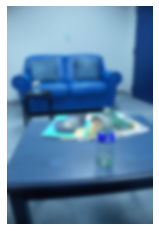

In [174]:
gt = cv2.imread('D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\\01_no_challenge\\4_5_1_001_01_0.jpg')
# gt = cv2.imread('D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\Ground_Truth\\01.png')
gt_img = Image.fromarray(gt, 'RGB')
gt = gt.astype('float64') / 255.0
print("GT",gt)
# gauss_bm3d_noisy = addNoise(gt, 'GAUSSIAN')
# gauss_bm3d_noisy_img = Image.fromarray(gauss_bm3d_noisy, 'RGB')
gauss_bm3d_noisy = cv2.imread('D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\\05_blur\\4_5_1_001_05_1.jpg')
gauss_bm3d_noisy = gauss_bm3d_noisy.astype('float64') / 255.0
print("Noisy",gauss_bm3d_noisy)
# gauss_bm3d_noisy = cv2.imread('D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\Set12_dataset\\Noisy\\01_gauss_noisy.png')
# gauss_bm3d_noisy_img = Image.fromarray(gt, 'RGB')

# sigma_range = np.arange(0.1, 0.9, 0.1)
# for i in range(len(sigma_range)):
gauss_bm3d_denoised = bm3d.bm3d(gauss_bm3d_noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES)
gauss_bm3d_denoised_img = Image.fromarray((gauss_bm3d_denoised * 255.0).astype(np.uint8), 'RGB')
print("Denoised",gauss_bm3d_denoised)

gauss_bm3d_denoise_psnr = peak_signal_noise_ratio(gt, gauss_bm3d_denoised)
gauss_bm3d_denoise_ssim = structural_similarity(gt, gauss_bm3d_denoised, data_range=gauss_bm3d_denoised.max() - gauss_bm3d_denoised.min(), channel_axis=2)
gauss_bm3d_denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(gauss_bm3d_denoised_img)
# denoised = np.ascontiguousarray((gauss_bm3d_denoised * 255.0).astype(np.uint8)) # for UNIQUE IQA Metric
# noise_unique = eng.unique((gt * 255.0).astype(np.uint8), denoised)

print("Denoise PSNR:", np.round(gauss_bm3d_denoise_psnr, 4), "dB")
print("Denoise SSIM", np.round(gauss_bm3d_denoise_ssim*100, 4), "%")
print("Denoise CW-SSIM", np.round(gauss_bm3d_denoise_cw*100, 4), "%")
print("\n")
# print("noisy image shape", gauss_bm3d_noisy.shape)
# print("denoised image shape", gauss_bm3d_denoised.shape)
# print(noise_unique)
plt.imshow(gauss_bm3d_denoised)
plt.axis('off')


## BM3D for all CURE-OR Images

In [116]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\08_dirtylens2'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised_final = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised_final))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(noisy, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 08 Dirty Lens 2 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_08_dirtylens2_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("CURE-OR Underexposure IQA Metrics saved at:", '\\CURE_OR_03_Underexposure_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_08_dirtylens2_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2
4_5_1_001_08_1.jpg
4_5_1_001_01_0.jpg


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_bm3d_denoised\4_5_1_001_08_1_bm3d_denoised.jpg
4_5_1_002_08_1.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_bm3d_denoised\4_5_1_002_08_1_bm3d_denoised.jpg
4_5_1_003_08_1.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_bm3d_denoised\4_5_1_003_08_1_bm3d_denoised.jpg
4_5_1_004_08_1.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_bm3d_denoised\4_5_1_004_08_1_bm3d_denoised.jpg
4_5_1_005_08_1.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\D

# Level 5 BM3D

In [165]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\03_underexposure_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    # noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 03 Underexposure Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_03_underexposure_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_03_underexposure_level3_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_03_underexposure_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3
4_5_1_001_03_3.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3_bm3d_denoised\4_5_1_001_03_3_bm3d_denoised.jpg
4_5_1_002_03_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3_bm3d_denoised\4_5_1_002_03_3_bm3d_denoised.jpg
4_5_1_003_03_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_level3_bm3d_denoised\4_5_1_003_03_3_bm3d_denoised.jpg
4_5_1_004_03_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\03_underexposure_

In [166]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\04_overexposure_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    # noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 04 Overexposure Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_04_overexposure_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_04_overexposure_level3_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_04_overexposure_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\04_overexposure_level3
4_5_1_001_04_3.jpg
4_5_1_001_01_0.jpg


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\04_overexposure_level3_bm3d_denoised\4_5_1_001_04_3_bm3d_denoised.jpg
4_5_1_002_04_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\04_overexposure_level3_bm3d_denoised\4_5_1_002_04_3_bm3d_denoised.jpg
4_5_1_003_04_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\04_overexposure_level3_bm3d_denoised\4_5_1_003_04_3_bm3d_denoised.jpg
4_5_1_004_04_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\04_overexposure_level3_bm3d_denoised\4_5_1_004_04_3_bm3d_denoised.jpg
4_5_1_005_04_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall

In [167]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\05_blur_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    # noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 05 Blur Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_05_blur_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_05_blur_level3_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_05_blur_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3
4_5_1_001_05_3.jpg
4_5_1_001_01_0.jpg


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_bm3d_denoised\4_5_1_001_05_3_bm3d_denoised.jpg
4_5_1_002_05_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_bm3d_denoised\4_5_1_002_05_3_bm3d_denoised.jpg
4_5_1_003_05_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_bm3d_denoised\4_5_1_003_05_3_bm3d_denoised.jpg
4_5_1_004_05_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\05_blur_level3_bm3d_denoised\4_5_1_004_05_3_bm3d_denoised.jpg
4_5_1_005_05_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Proje

In [168]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\06_contrast_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    # noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_psnr = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 06 Contrast Level 5 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_06_contrast_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_06_contrast_level3_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_06_contrast_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3
4_5_1_001_06_3.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_bm3d_denoised\4_5_1_001_06_3_bm3d_denoised.jpg
4_5_1_002_06_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_bm3d_denoised\4_5_1_002_06_3_bm3d_denoised.jpg
4_5_1_003_06_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_bm3d_denoised\4_5_1_003_06_3_bm3d_denoised.jpg
4_5_1_004_06_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\06_contrast_level3_bm3d_denoised\4_5_

In [169]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\07_dirtylens1_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    # noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(noisy, denoised)
    denoise_psnr = structural_similarity(noisy, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(noisy_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 07 Dirty Lens 1 Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_07_dirtylens1_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_07_dirtylens1_level3_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_07_dirtylens1_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3
4_5_1_001_07_3.jpg
4_5_1_001_01_0.jpg


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_bm3d_denoised\4_5_1_001_07_3_bm3d_denoised.jpg
4_5_1_002_07_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_bm3d_denoised\4_5_1_002_07_3_bm3d_denoised.jpg
4_5_1_003_07_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_bm3d_denoised\4_5_1_003_07_3_bm3d_denoised.jpg
4_5_1_004_07_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\07_dirtylens1_level3_bm3d_denoised\4_5_1_004_07_3_bm3d_denoised.jpg
4_5_1_005_07_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 co

In [170]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\08_dirtylens2_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(noisy, denoised)
    denoise_psnr = structural_similarity(noisy, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(noisy_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 08 Dirty Lens 2 Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_08_dirtylens2_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_08_dirtylens2_level3_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_08_dirtylens2_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3
4_5_1_001_08_3.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_bm3d_denoised\4_5_1_001_08_3_bm3d_denoised.jpg
4_5_1_002_08_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_bm3d_denoised\4_5_1_002_08_3_bm3d_denoised.jpg
4_5_1_003_08_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_bm3d_denoised\4_5_1_003_08_3_bm3d_denoised.jpg
4_5_1_004_08_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3_bm3d_den

# 08 Dirty Lens 2

## NLM

In [ ]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\08_dirtylens2'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    # noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(noisy, denoised)
    denoise_ssim = structural_similarity(noisy, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(noisy_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 08 Dirty Lens 2 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_08_dirtylens2.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_08_dirtylens2.pkl')

with open(directory+'\\CURE_OR_BM3D_08_dirtylens2.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


In [9]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\08_dirtylens2_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    # noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(noisy, denoised)
    denoise_ssim = structural_similarity(noisy, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(noisy_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 08 Dirty Lens 2 Level 3distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_08_dirtylens2_level3.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_08_dirtylens2_level3.pkl')

with open(directory+'\\CURE_OR_BM3D_08_dirtylens2_level3.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\08_dirtylens2_level3
4_5_1_001_08_3.jpg
4_5_1_001_01_0.jpg


KeyboardInterrupt: 

# 09 S&P Noise

## BM3D

In [12]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\09_spnoise'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_ssim = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 09 S&P Noise distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_09_spnoise_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_09_spnoise_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_09_spnoise_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise
4_5_1_001_09_1.jpg
4_5_1_001_01_0.jpg


Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_bm3d_denoised\4_5_1_001_09_1_bm3d_denoised.jpg
4_5_1_002_09_1.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_bm3d_denoised\4_5_1_002_09_1_bm3d_denoised.jpg
4_5_1_003_09_1.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_bm3d_denoised\4_5_1_003_09_1_bm3d_denoised.jpg
4_5_1_004_09_1.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_bm3d_denoised\4_5_1_004_09_1_bm3d_denoised.jpg
4_5_1_005_09_1.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE

In [13]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\09_spnoise_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_ssim = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 09 S&P Noise distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_09_spnoise_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_09_spnoise-level3_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_09_spnoise_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3
4_5_1_001_09_3.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_bm3d_denoised\4_5_1_001_09_3_bm3d_denoised.jpg
4_5_1_002_09_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_bm3d_denoised\4_5_1_002_09_3_bm3d_denoised.jpg
4_5_1_003_09_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_bm3d_denoised\4_5_1_003_09_3_bm3d_denoised.jpg
4_5_1_004_09_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_bm3d_denoised\4_5_1_004

In [14]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\09_spnoise_level5'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')
    noisy = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = bm3d.bm3d(noisy, sigma_psd=0.13, stage_arg=bm3d.BM3DStages.ALL_STAGES) #nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_bm3d_denoised\\' + filename[:-4] + '_bm3d_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_ssim = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"BM3D 09 S&P Noise Level 5 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_BM3D_09_spnoise_level5_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("Metrics saved at:", '\\CURE_OR_BM3D_09_spnoise-level5_IQA.pkl')

with open(directory+'\\CURE_OR_BM3D_09_spnoise_level5_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)


D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5
4_5_1_001_09_5.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_bm3d_denoised\4_5_1_001_09_5_bm3d_denoised.jpg
4_5_1_002_09_5.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_bm3d_denoised\4_5_1_002_09_5_bm3d_denoised.jpg
4_5_1_003_09_5.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_bm3d_denoised\4_5_1_003_09_5_bm3d_denoised.jpg
4_5_1_004_09_5.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_bm3d_denoised\4_5_1_004

## 09 SP Noise NLM

In [10]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\09_spnoise'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)
    

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_ssim = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"09 SP Noise distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_09_spnoise_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("CURE-OR Underexposure IQA Metrics saved at:", '\\CURE_OR_09_spnoise_IQA.pkl')

with open(directory+'\\CURE_OR_09_spnoise_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise
4_5_1_001_09_1.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_denoised\4_5_1_001_09_1_denoised.jpg


<ipython-input-10-67fdf6bea1f9>:33: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_09_1.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_denoised\4_5_1_002_09_1_denoised.jpg
4_5_1_003_09_1.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_denoised\4_5_1_003_09_1_denoised.jpg
4_5_1_004_09_1.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_denoised\4_5_1_004_09_1_denoised.jpg
4_5_1_005_09_1.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_denoised\4_5_1_005_09_1_denoised.jpg
4_5_1_006_09_1.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-O

In [11]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\09_spnoise_level3'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)
    

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_ssim = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"09 SP Noise Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_09_spnoise_level3_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("CURE-OR Underexposure IQA Metrics saved at:", set_12_dir+'\\CURE_OR_09_spnoise_level3_IQA.pkl')

with open(directory+'\\CURE_OR_09_spnoise_level3_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3
4_5_1_001_09_3.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_denoised\4_5_1_001_09_3_denoised.jpg


<ipython-input-11-1ab57264d01d>:33: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_09_3.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_denoised\4_5_1_002_09_3_denoised.jpg
4_5_1_003_09_3.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_denoised\4_5_1_003_09_3_denoised.jpg
4_5_1_004_09_3.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_denoised\4_5_1_004_09_3_denoised.jpg
4_5_1_005_09_3.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level3_denoised\4_5_1_005_09_3_denoised.jpg
4_5_1_006_09_3.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258

In [9]:
directory = 'D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR'
gt_dir = directory + '\\01_no_challenge'
noisy_dir = directory + '\\09_spnoise_level5'
print(noisy_dir)

img_prefix = '4_5_1_'
cure_or_iqa_pkl = {'001': [], '002': [], '003': [], '004': [], '005': [], '006': [], '007': [], '008': [], '009': [], '010': []}

for filename in os.listdir(noisy_dir):
    print(filename)
    gt_filename = img_prefix + filename[6:9] + '_01_0.jpg'
    
    gt = cv2.imread(gt_dir + '\\' + gt_filename)
    print(gt_filename)
    gt_img = Image.fromarray(gt, 'RGB')
    # gt = gt.astype('float64') / 255.0

    noisy = cv2.imread(noisy_dir + '\\' + filename)
    noisy_img = Image.fromarray(noisy, 'RGB')

    noise_psnr = peak_signal_noise_ratio(gt, noisy)
    noise_ssim = structural_similarity(gt, noisy, data_range=noisy.max() - noisy.min(), channel_axis=2)
    noise_cw = pyssim.SSIM(gt_img).cw_ssim_value(noisy_img)

    denoised = nonLocalMeans(noisy)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    denoised = denoised* 255.0
    denoised_file_save = noisy_dir + '_denoised\\' + filename[:-4] + '_denoised.jpg'
    cv2.imwrite(denoised_file_save, np.array(denoised))
    print("Denoised Image saved at: ", denoised_file_save)
    

    denoise_psnr = peak_signal_noise_ratio(gt, denoised)
    denoise_ssim = structural_similarity(gt, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = pyssim.SSIM(gt_img).cw_ssim_value(denoised_img)

    cure_or_iqa = {"09 SP Noise Level 3 distortion": (str(noise_psnr)+' dB', str(noise_ssim)+' %', str(noise_cw)+' %'), "NLM Denoise": (str(denoise_psnr)+' dB', str(denoise_ssim)+' %', str(denoise_cw))}
    file_index = filename[6:9]
    cure_or_iqa_pkl[file_index].append(cure_or_iqa)
print(cure_or_iqa_pkl)

with open(directory+'\\CURE_OR_09_spnoise_level5_IQA.pkl', 'wb') as pkl_file:
    pickle.dump(cure_or_iqa_pkl, pkl_file)
    print("CURE-OR Underexposure IQA Metrics saved at:", set_12_dir+'\\CURE_OR_09_spnoise_level5_IQA.pkl')

with open(directory+'\\CURE_OR_09_spnoise_level5_IQA.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print('IQA LensBlur')
    print(iqa)

D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5
4_5_1_001_09_5.jpg
4_5_1_001_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_denoised\4_5_1_001_09_5_denoised.jpg


<ipython-input-9-6f62d1c0fd83>:33: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoise_psnr = peak_signal_noise_ratio(gt, denoised)


4_5_1_002_09_5.jpg
4_5_1_002_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_denoised\4_5_1_002_09_5_denoised.jpg
4_5_1_003_09_5.jpg
4_5_1_003_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_denoised\4_5_1_003_09_5_denoised.jpg
4_5_1_004_09_5.jpg
4_5_1_004_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_denoised\4_5_1_004_09_5_denoised.jpg
4_5_1_005_09_5.jpg
4_5_1_005_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258 DIP\Project\Datasets\CURE-OR\09_spnoise_level5_denoised\4_5_1_005_09_5_denoised.jpg
4_5_1_006_09_5.jpg
4_5_1_006_01_0.jpg
Denoised Image saved at:  D:\Padips\MS Docs\Georgia Tech\Coursework\Fall 2023 courses\ECE 6258